In [ ]:
import random
import pandas as pd
import warnings
from sklearn import *
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, mean_squared_error, r2_score, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
!pip install optuna sqlalchemy --quiet
import optuna
import sqlalchemy
from sklearn.model_selection import cross_val_score, cross_validate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.2 MB/s eta 0:00:00


In [ ]:
#pip freeze > requirements.txt
#!pip install -r xgboost_requirements.txt


In [ ]:
np.random.seed(42)
data = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')
#print(data.isnull().sum())
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

# Baseline Model

In [ ]:
# Encode categorical variables using one-hot encoding
data = pd.get_dummies(data, drop_first=True)

In [ ]:
# Test train split baseline model
X = data.drop(columns=['Diabetes_012'])
y = data['Diabetes_012']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify= y_temp)

              precision    recall  f1-score   support

         0.0       0.86      0.97      0.92     34193
         1.0       0.00      0.00      0.00       741
         2.0       0.53      0.19      0.28      5655

    accuracy                           0.85     40589
   macro avg       0.47      0.39      0.40     40589
weighted avg       0.80      0.85      0.81     40589

Precision: 0.8017404883010503
Recall: 0.8473478035921063
F1 Score: 0.8101806356670375


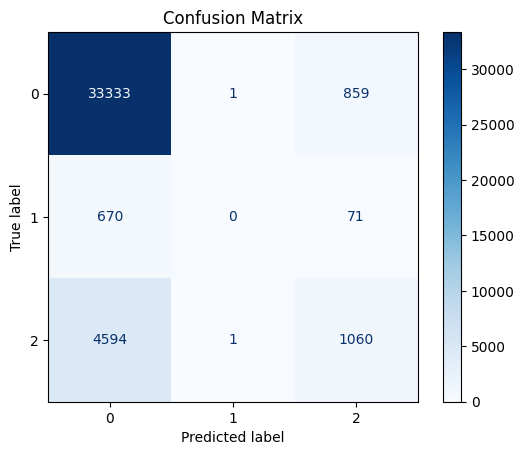

In [ ]:
# Train the model with GPU
xgboost = XGBClassifier(use_label_encoder=True, eval_metric='logloss')
xgboost.fit(X_train, y_train)

# Prediction
y_val_pred = xgboost.predict(X_val)

# Evaluate the model
precision = precision_score(y_val, y_val_pred, average = 'weighted')
recall = recall_score(y_val, y_val_pred, average = 'weighted')
f1 = f1_score(y_val, y_val_pred, average = 'weighted')
baseline_report = classification_report(y_val, y_val_pred)

print(baseline_report)
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgboost.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

The classification report reveals that the model performs well for the non-diabetic class (0.0), with high precision (0.86), recall (0.97), and F1-score (0.92) for the 34,193 samples in this class. However, the model struggles significantly with the pre-diabetic class (1.0), failing entirely to make accurate predictions, as indicated by precision, recall, and F1-scores all being 0.00 for the 741 samples in this class. For the diabetic class (2.0), the model shows moderate performance with a precision of 0.53 and a low recall of 0.19, resulting in an F1-score of 0.28 for the 5,655 samples in this class.

Overall, the model achieves a high accuracy of 0.85, with a weighted average precision of 0.80, recall of 0.85, and F1-score of 0.81. However, the (precision: 0.47, recall: 0.39, F1-score: 0.40) highlight the model's poor performance on the minority classes. The confusion matrix further illustrates this imbalance, showing that while the model performs well for the majority class, it fails to generalize well for the minority classes.

# Modified XGBoost

In [ ]:
df = data.copy()
# Separate features and target
X = df.drop(columns=['Diabetes_012'])
y = df['Diabetes_012']

# Split the data ensuring stratification
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp)

In [ ]:
# Feature engineering
# Impute missing values
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

# Apply SMOTE to the training data only
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_imputed, y_train)

# Check class distribution in the resampled training set
print("Class distribution after SMOTE:")
print(y_train_res.value_counts())

# Apply PCA
pca = PCA(n_components=15)
X_train_res_pca = pca.fit_transform(X_train_res)
X_train_res_pca_df = pd.DataFrame(X_train_res_pca)
X_val_pca = pca.transform(X_val_imputed)
X_val_pca_df = pd.DataFrame(X_val_pca)

Class distribution after SMOTE:
Diabetes_012
0.0    136769
2.0    136769
1.0    136769
Name: count, dtype: int64


              precision    recall  f1-score   support

         0.0       0.91      0.81      0.86     34193
         1.0       0.03      0.07      0.05       741
         2.0       0.36      0.56      0.43      5655

    accuracy                           0.76     40589
   macro avg       0.43      0.48      0.45     40589
weighted avg       0.82      0.76      0.78     40589

Precision: 0.8197424331028885
Recall: 0.7592943901056937
F1 Score: 0.7835072354507209


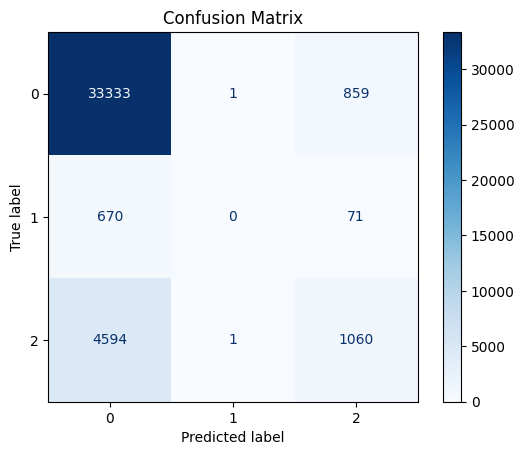

In [ ]:
# Train a weighted XGBoost model without scale_pos_weight
xgb_model_weighted = XGBClassifier(use_label_encoder=True, eval_metric='logloss')
xgb_model_weighted.fit(X_train_res_pca, y_train_res)

# Prediction
y_val_pred_weighted = xgb_model_weighted.predict(X_val_pca)

# Evaluate the model
precision = precision_score(y_val, y_val_pred_weighted, average='weighted')
recall = recall_score(y_val, y_val_pred_weighted, average='weighted')
f1 = f1_score(y_val, y_val_pred_weighted, average='weighted')

print(classification_report(y_val, y_val_pred_weighted))
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model_weighted.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

This model take into account imbalancing by utilizing SMOTE and Principal Component Analysis (PCA). For the Non-Diabetic class (Class 0), the model has high precision (0.91), recall (0.81), and F1-score (0.86), indicating strong performance with most predictions being correct. In contrast, the model struggles significantly with the Pre-Diabetic class (Class 1), showing very low precision (0.03), recall (0.07), and F1-score (0.05). This suggests that the model is ineffective at identifying Pre-Diabetic cases. For the Diabetic class (Class 2), the model achieves moderate recall (0.56) but lower precision (0.36), leading to an F1-score of 0.43. This indicates that while the model can identify many diabetic cases, it also has a high rate of false positives.

Overall, the model achieves an accuracy of 0.76, meaning 76% of the total predictions are correct. The macro average, which is the simple average of precision, recall, and F1 scores for all classes, shows lower values (precision: 0.43, recall: 0.48, F1-score: 0.45) due to the poor performance on the minority classes. The weighted average, which accounts for the class distribution, shows higher values (precision: 0.82, recall: 0.76, F1-score: 0.78), reflecting the model's strong performance on the majority class. The evaluation reveals that the model performs well on the majority class (Non-Diabetic) but poorly on the minority classes (Pre-Diabetic and Diabetic), especially the Pre-Diabetic class.

In [13]:
# Define the objective function
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0.1, 0.4, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5)
    }

    xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', **param)

    # Define the scoring metrics
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision_weighted',
        'recall': 'recall_weighted',
        'f1': 'f1_weighted'
    }

    # Perform cross-validation
    scores = cross_validate(xgb_model, X_train_res_pca, y_train_res, cv=3, scoring=scoring)

    # Log each metric
    trial.set_user_attr('accuracy', scores['test_accuracy'].mean())
    trial.set_user_attr('precision', scores['test_precision'].mean())
    trial.set_user_attr('recall', scores['test_recall'].mean())
    trial.set_user_attr('f1', scores['test_f1'].mean())

    # Return the main metric to optimize
    return scores['test_f1'].mean()

# Ensure the directory for the database exists
db_path = "optuna_study.db"

# Create an SQLite database URL
db_url = f"sqlite:///{db_path}"

# Create a study object with SQLite storage
study = optuna.create_study(direction='maximize', storage=db_url, study_name="xgb_study", load_if_exists=True)

# Number of trials
n_trials = 50

# Optimize
study.optimize(objective, n_trials=n_trials)

# Print best trial results
print("Best trial:")
best_trial = study.best_trial
print(f"  Value (F1 Score): {best_trial.value}")
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Print additional metrics
print(f"  Accuracy: {best_trial.user_attrs['accuracy']}")
print(f"  Precision: {best_trial.user_attrs['precision']}")
print(f"  Recall: {best_trial.user_attrs['recall']}")
print(f"  F1 Score: {best_trial.user_attrs['f1']}")

# Save the optuna study
study.trials_dataframe().to_csv("optuna_trials.csv")


[I 2024-06-19 00:09:24,371] Using an existing study with name 'xgb_study' instead of creating a new one.
[I 2024-06-19 00:12:41,533] Trial 8 finished with value: 0.8758629829545854 and parameters: {'n_estimators': 263, 'max_depth': 9, 'learning_rate': 0.14026761120536899, 'subsample': 0.8354497262066609, 'colsample_bytree': 0.7589665600097402, 'gamma': 0.12803700818366687, 'min_child_weight': 4}. Best is trial 8 with value: 0.8758629829545854.
[I 2024-06-19 00:17:03,758] Trial 9 finished with value: 0.8521451309618219 and parameters: {'n_estimators': 291, 'max_depth': 10, 'learning_rate': 0.05057518703413811, 'subsample': 0.8321730619122159, 'colsample_bytree': 0.6852152115702055, 'gamma': 0.36856630336810947, 'min_child_weight': 5}. Best is trial 8 with value: 0.8758629829545854.
[I 2024-06-19 00:19:50,685] Trial 10 finished with value: 0.6921220519744887 and parameters: {'n_estimators': 244, 'max_depth': 8, 'learning_rate': 0.013430336781207376, 'subsample': 0.6396427271613948, 'cols

Best trial:
  Value (F1 Score): 0.9082202187510854
  Params: 
    n_estimators: 254
    max_depth: 10
    learning_rate: 0.18093178433138304
    subsample: 0.942028429191144
    colsample_bytree: 0.806737204690533
    gamma: 0.13308009758327644
    min_child_weight: 2
  Accuracy: 0.9087244429171327
  Precision: 0.911256056121777
  Recall: 0.9087244429171327
  F1 Score: 0.9082202187510854


The Optuna optimization process effectively identified the best hyperparameters. The goal was to maximize the weighted F1 score, a measure that balances precision and recall. The chosen hyperparameters for the best trial include 254 estimators, a maximum depth of 10, a learning rate of approximately 0.18, a subsample ratio of 0.94, a column sample by tree ratio of 0.81, a gamma value of 0.13, and a minimum child weight of 2. These settings led to the highest performance metrics recorded in the optimization process.

The model's evaluation metrics from this best trial are impressive. It achieved an accuracy of about 90.87%, indicating that most predictions were correct. The precision, at 91.13%, shows that the model made very few false positive predictions. The recall, also at 90.87%, reveals that the model successfully identified a large proportion of actual positive cases. The F1 score, which harmonizes precision and recall, stood at 90.82%, demonstrating a balanced performance.

              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89     34193
         1.0       0.03      0.01      0.02       741
         2.0       0.38      0.41      0.40      5655

    accuracy                           0.81     40589
   macro avg       0.43      0.44      0.43     40589
weighted avg       0.80      0.81      0.80     40589

Accuracy: 0.8051935253393777
Precision: 0.8026923956484705
Recall: 0.8051935253393777
F1 Score: 0.8038310864577903


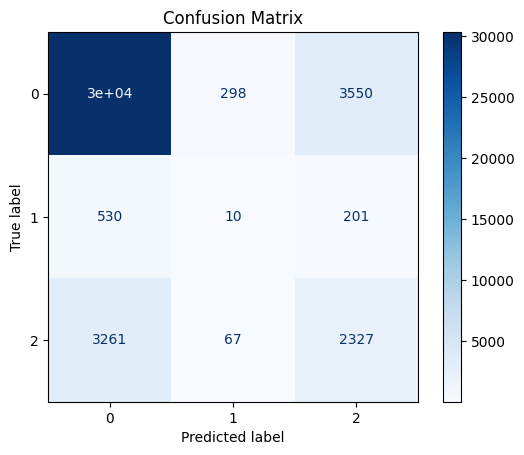

In [15]:
# Load the CSV file
#trials_df = pd.read_csv("optuna_trials.csv")
# Identify the row with the best value (assuming higher is better for the objective)
#best_trial = trials_df.loc[trials_df['value'].idxmax()]

# Extract the best parameters
best_params = {
    'n_estimators': best_trial.params['n_estimators'],
    'max_depth': best_trial.params['max_depth'],
    'learning_rate': best_trial.params['learning_rate'],
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree'],
    'gamma': best_trial.params['gamma'],
    'min_child_weight': best_trial.params['min_child_weight']
}

# Initialize the final XGBoost model with the best parameters
final_xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', **best_params)

# Train the model on the entire training data
final_xgb_model.fit(X_train_res_pca, y_train_res)

# Make predictions on the validation set
y_val_pred = final_xgb_model.predict(X_val_pca)

# Evaluate the model using multiple metrics
precision = precision_score(y_val, y_val_pred, average='weighted')
recall = recall_score(y_val, y_val_pred, average='weighted')
f1 = f1_score(y_val, y_val_pred, average='weighted')
accuracy = final_xgb_model.score(X_val_pca, y_val)

print(classification_report(y_val, y_val_pred))
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Generate confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_xgb_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

The results indicate that the model performs exceptionally well on the majority class (Non-Diabetic), with high precision, recall, and F1 scores of 0.89 each, and an accuracy of 0.81. However, the model struggles significantly with the minority classes, particularly the Pre-Diabetic class, where it achieves a very low F1 score of 0.02, indicating poor performance. The Diabetic class shows moderate results, with a precision of 0.38 and a recall of 0.41. The confusion matrix visually confirms these findings, showing that the model correctly identifies most Non-Diabetic cases but misclassifies a substantial number of Pre-Diabetic and Diabetic cases.